## NLP 

In [ ]:
import dill
dill.load_session('hate_speech.db')

In [ ]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
import re 
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from string import punctuation
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from english_words import english_words_lower_set
import dill
%matplotlib inline
nltk.download('stopwords')
nltk.download('words')
stemmer = PorterStemmer()
other_exclusions = ["#ff", "ff", "rt"]

                                              Features and target description
                                              
                                              
- count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

- hate_speech = number of CF users who judged the tweet to be hate speech.

- offensive_language = number of CF users who judged the tweet to be offensive.

- neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

- class = class label for majority of CF users.
    0 - hate speech 
    1 - offensive language 
    2 - neither

In [2]:
#importing the dataset 
dataset_path = "hate_speech.csv"  
dataset = pd.read_csv(filepath_or_buffer=dataset_path)  
# the dataset consist of 24560 rows 
#visualising the first 10 rows   
dataset.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [3]:
#droping the 'Unnamed' and 'count' columns 
columns_to_keep =['hate_speech','offensive_language','neither','tweet','class']
dataset = dataset.reindex(columns=columns_to_keep) 
dataset = dataset[columns_to_keep].dropna()
#checking for null and empty values
null_values_sum = dataset.isnull().sum() 
print("the total of null value in the dataset :\n {0}".format(null_values_sum))
for i in dataset.columns :
       print("empty value in {0} : {1}".format(i,dataset[i].empty))

the total of null value in the dataset :
 hate_speech           0
offensive_language    0
neither               0
tweet                 0
class                 0
dtype: int64
empty value in hate_speech : False
empty value in offensive_language : False
empty value in neither : False
empty value in tweet : False
empty value in class : False


                 As we can see from the histogram below most of the tweets in our dataset were coded as class 1 which is "offensive language"

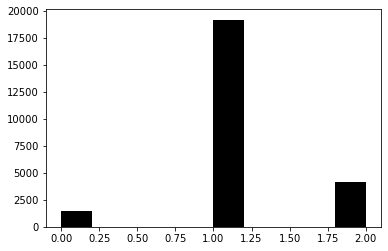

In [4]:
plt.hist(dataset['class'],color="black")
plt.show()

  Distribution of text length is similar across all three classes

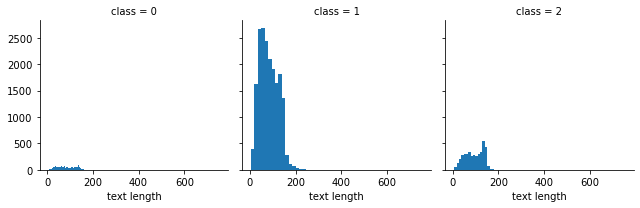

In [5]:
dataset['text length'] = dataset.tweet.apply(len)
len_graph = sns.FacetGrid(data=dataset, col = 'class')
len_graph.map(plt.hist,'text length',bins=50)

                                                   TEXT PREPROCESSING

 When dealing with text data in machine learning it's necessary to use NLP(natural language processing) libraries in order to cllean the data, in this case we will be using Natural Language Toolkit.

 there are multiple text processing steps :
 
 - 1 -  Removing punctuations (e.g : ! $( ) * % @)
 
 - 2 - Removing Stop words

 - 3 - Tokenization 

 - 4 - Stemming  

 - 5 - Lemmatization
 


In [6]:
""" the tweet column contains punctuation and other characters that need to be removed 
    in order to have a clean text. 
"""

#defining the function to remove punctuation

def remove_punctuation(text):
    text_punctuation_free = "".join([i for i in text if i not in punctuation])
    return text_punctuation_free

#storing the puntuation free text

dataset['tweet'] = dataset['tweet'].apply(lambda x: remove_punctuation(x))
dataset.head(10)


,hate_speech,offensive_language,neither,tweet,class,text length
0,0,0,3,RT mayasolovely As a woman you shouldnt compl...,2,140
1,0,3,0,RT mleew17 boy dats coldtyga dwn bad for cuff...,1,85
2,0,3,0,RT UrKindOfBrand Dawg RT 80sbaby4life You eve...,1,120
3,0,2,1,RT CGAnderson vivabased she look like a tranny,1,62
4,0,6,0,RT ShenikaRoberts The shit you hear about me ...,1,137
5,1,2,0,TMadisonx The shit just blows meclaim you so f...,1,158
6,0,3,0,BrighterDays I can not just sit up and HATE on...,1,105
7,0,3,0,8220selfiequeenbri cause Im tired of you big b...,1,98
8,0,3,0,amp you might not get ya bitch back amp thats...,1,58
9,1,2,0,rhythmixx hobbies include fighting Mariam\n\n...,1,55


In [7]:
# transform text to lower case
dataset['tweet'] = dataset['tweet'].apply(lambda x: x.lower())
dataset.tweet.head(10)

0     rt mayasolovely as a woman you shouldnt compl...
1     rt mleew17 boy dats coldtyga dwn bad for cuff...
2     rt urkindofbrand dawg rt 80sbaby4life you eve...
3       rt cganderson vivabased she look like a tranny
4     rt shenikaroberts the shit you hear about me ...
5    tmadisonx the shit just blows meclaim you so f...
6    brighterdays i can not just sit up and hate on...
7    8220selfiequeenbri cause im tired of you big b...
8     amp you might not get ya bitch back amp thats...
9     rhythmixx hobbies include fighting mariam\n\n...
Name: tweet, dtype: object

In [8]:

##### removing white spaces,links and @name from the tweets using regular expressions #####

tweet = dataset.tweet
stopwords = stopwords.words('english')

# removal of extra spaces

regex_space = re.compile(r'\s+')
tweet = tweet.str.replace(regex_space, ' ')

# removal of numbers

regex_number = re.compile(r'\d+(\.\d+)?')
tweet = tweet.str.replace(regex_number, ' ')

# removal of @mention
regex_mention = re.compile(r'@[\w\-]+')
tweet = tweet.str.replace(regex_mention, '')

# removal of links
regex_url = re.compile(
    'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
tweet = tweet.str.replace(regex_url, '')

# removal of stopwords

stopwords.extend(other_exclusions) 
tweet = tweet.apply(lambda x: x.split())
tweet = tweet.apply(
    lambda x: [item for item in x if item not in stopwords])
 
#  our new tweets are in a form of a list that is free of stopwords, we need to form a new string
for index in range(len(tweet)):
    tweet[index] = " ".join(tweet[index])
    tweet = tweet
dataset.tweet = tweet


In [9]:
# the new data in tweet column is free of number,stop words, extra spaces which can help with reducuing dimensionality problem
dataset.tweet 

0        mayasolovely woman shouldnt complain cleaning ...
1        mleew boy dats coldtyga dwn bad cuffin dat hoe...
2        urkindofbrand dawg sbaby life ever fuck bitch ...
3                    cganderson vivabased look like tranny
4        shenikaroberts shit hear might true might fake...
                               ...                        
24778    yous muthafin lie lifeasking pearls coreyemanu...
24779    youve gone broke wrong heart baby drove rednec...
24780    young buck wanna eat dat nigguh like aint fuck...
24781                    youu got wild bitches tellin lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 24783, dtype: object

                                                    Feature Extraction

Term Frequency Inverse Document Frequency (TFIDF) :

- there's no machine algorithm that understand and can used human being language, ML algorithms need to be provided with numerical data in order to be trained,
here we're using TFIDF to transform the text into vectors, 

- TF : TERM FREQUENCY

- IDF : INVERSE DOCUMENT FREQUENCY

the TFIDF vectorizer class has many parameters, the performance of our Models will depend on these parammeters, at first i will choose the values of this parameters randomly and manually and then we check the results.

TFIDF vectorizer parameters : 
- max_features: This parameter enables using only the ‘n’ most frequent words as features instead of all the words.

- ngram_range: An n-gram is a string of words in a row. For example, in the sentence – 
“playing football is easy”, 2-grams could be 'playing football' , 'football is' or ‘is easy’.
The default ngram_range is (1,1).

- min_df, max_df: These refer to the minimum and maximum document frequency that a word/n-gram should have to be used as a feature. 
The frequency here refers to the proportion of documents. Both the parameters have to be set in the range of [0,1].



In [10]:

tfidf = TfidfVectorizer(ngram_range=(
    1, 2), max_df=0.7, min_df=5, max_features=1000)

vectorized_tweets = tfidf.fit_transform(dataset['tweet'])

# each token (words) is converted to a feature token in the matrix
# Tfidfvectorizer creat a vocabulary of features
i = 0

print(tfidf.get_feature_names())

['act', 'act like', 'actin', 'acting', 'acting like', 'actually', 'af', 'ago', 'ah', 'aint', 'aint bitch', 'aint got', 'aint hoe', 'aint loyal', 'aint shit', 'almost', 'alone', 'already', 'also', 'always', 'america', 'american', 'amp', 'annoying', 'another', 'another bitch', 'answer', 'anymore', 'anyone', 'anything', 'anyway', 'arent', 'around', 'asian', 'ask', 'asked', 'asking', 'ass', 'ass bitch', 'ass bitches', 'ass hoe', 'ass hoes', 'ass nigga', 'ass niggas', 'ate', 'attention', 'attitude', 'avi', 'away', 'aye', 'baby', 'back', 'bad', 'bad bitch', 'bad bitches', 'baddest', 'bae', 'bag', 'ball', 'balls', 'basic', 'basically', 'bc', 'beat', 'beautiful', 'become', 'bed', 'beer', 'behind', 'believe', 'best', 'bet', 'better', 'big', 'big booty', 'biggest', 'bird', 'birds', 'birthday', 'bitch', 'bitch aint', 'bitch amp', 'bitch ass', 'bitch bitch', 'bitch cant', 'bitch dont', 'bitch fuck', 'bitch get', 'bitch go', 'bitch got', 'bitch im', 'bitch know', 'bitch like', 'bitch lol', 'bitch l

                          Visualizing which words are most commonly used in hatred speech in tweet dataset

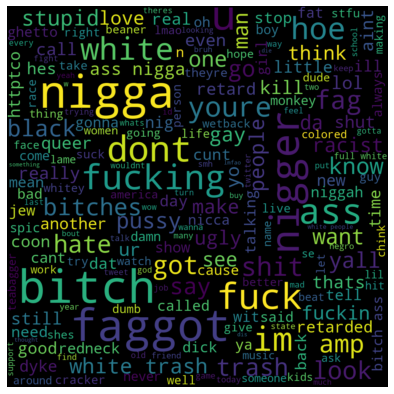

In [11]:
hate_speech = ''.join([text for text in dataset['tweet'][dataset['class']==0]])
wordcloud = WordCloud(width=1000,height = 1000,random_state=21,max_font_size=120).generate(hate_speech)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

                                                SPLITTING DATASET TO TRAIN AND TEST DATA 

In [ ]:
# 80% OF THE DATASET WILL BE TRAIN DATA AND 20% WILL BE TRAIN DATA
X, Y = vectorized_tweets.todense(), dataset['class']
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, random_state=42, test_size=0.2)


                                          LOGISTIC REGRESSION 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.55      0.16      0.25       290
           1       0.91      0.96      0.94      3832
           2       0.84      0.82      0.83       835

    accuracy                           0.89      4957
   macro avg       0.77      0.65      0.67      4957
weighted avg       0.88      0.89      0.88      4957

logistic regression accuracy score: 0.8926770223925762


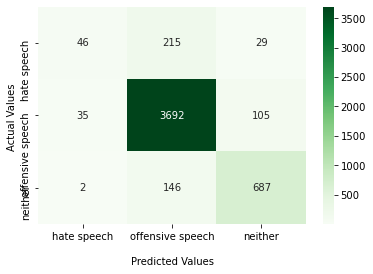

In [13]:
#selecting the algorithm and train it on the train set 
model_logistic_regression = LogisticRegression()
model = model_logistic_regression.fit(X_train, Y_train)

#predicting the class from the test set
y_predictions = model_logistic_regression.predict(X_test)

#generating the classification report
report = classification_report(Y_test,y_predictions)
print(report)
mat = confusion_matrix(Y_test, y_predictions)

accuracy_logistic_regression = accuracy_score(Y_test,y_predictions)
print('logistic regression accuracy score: {}'.format(
    accuracy_logistic_regression))

# displaying confusion matrix 

heat_map = sns.heatmap(mat, annot=True, cmap='Greens', fmt="d")
heat_map.set_xlabel('\nPredicted Values')
heat_map.set_ylabel('Actual Values ')
heat_map.xaxis.set_ticklabels(['hate speech', 'offensive speech','neither'])
heat_map.yaxis.set_ticklabels(['hate speech', 'offensive speech', 'neither'])
plt.show()



                                                        SIMPLE VECTOR MACHINE           

              precision    recall  f1-score   support

           0       0.53      0.17      0.25       290
           1       0.92      0.96      0.94      3832
           2       0.83      0.89      0.86       835

    accuracy                           0.90      4957
   macro avg       0.76      0.67      0.68      4957
weighted avg       0.89      0.90      0.89      4957

SVM accuracy score: 0.8997377446035909


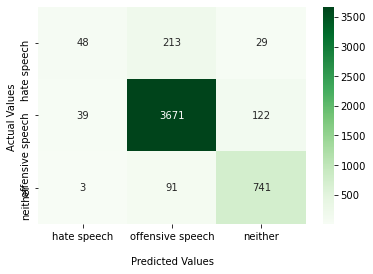

In [14]:
#selecting the algorithm and train it on the train set 
model_svm = svm.SVC(kernel='linear')
model_svm = model_svm.fit(X_train, Y_train)

#predicting the class from the test set
y_predictions = model_svm.predict(X_test)

#generating the classification report
report = classification_report(Y_test,y_predictions)
print(report)
mat = confusion_matrix(Y_test, y_predictions)
accuracy_svm = accuracy_score(Y_test, y_predictions)
print('SVM accuracy score: {}'.format(accuracy_svm))

# diplaying confusion matrix
heat_map = sns.heatmap(mat, annot=True, cmap='Greens', fmt="d")
heat_map.set_xlabel('\nPredicted Values')
heat_map.set_ylabel('Actual Values ')
heat_map.xaxis.set_ticklabels(['hate speech', 'offensive speech', 'neither'])
heat_map.yaxis.set_ticklabels(['hate speech', 'offensive speech', 'neither'])
plt.show()


                                            RANDOM FOREST

              precision    recall  f1-score   support

           0       0.53      0.12      0.20       290
           1       0.91      0.96      0.94      3832
           2       0.82      0.85      0.83       835

    accuracy                           0.89      4957
   macro avg       0.75      0.64      0.66      4957
weighted avg       0.88      0.89      0.88      4957

Random forest accuracy score: 0.8924752874722615


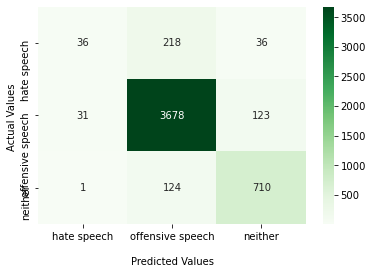

In [15]:
#selecting the algorithm and train it on the train set 
model_random_forest = RandomForestClassifier()
model_random_forest = model_random_forest.fit(X_train, Y_train)

#predicting the class from the test set
y_predictions = model_random_forest.predict(X_test)

#generating the classification report
report = classification_report(Y_test, y_predictions)
print(report)
accuracy_random_forest = accuracy_score(Y_test, y_predictions)
mat = confusion_matrix(Y_test, y_predictions)
print('Random forest accuracy score: {}'.format(accuracy_random_forest))
# diplaying confusion matrix
heat_map = sns.heatmap(mat, annot=True, cmap='Greens', fmt="d")
heat_map.set_xlabel('\nPredicted Values')
heat_map.set_ylabel('Actual Values ')
heat_map.xaxis.set_ticklabels(['hate speech', 'offensive speech', 'neither'])
heat_map.yaxis.set_ticklabels(['hate speech', 'offensive speech', 'neither'])
plt.show()


                                                                    NAIVE BAYES

              precision    recall  f1-score   support

           0       0.09      0.33      0.15       290
           1       0.88      0.70      0.78      3832
           2       0.55      0.58      0.57       835

    accuracy                           0.66      4957
   macro avg       0.51      0.54      0.50      4957
weighted avg       0.78      0.66      0.71      4957

 NAIVE BAYES accuracy score: 0.6614888037119225


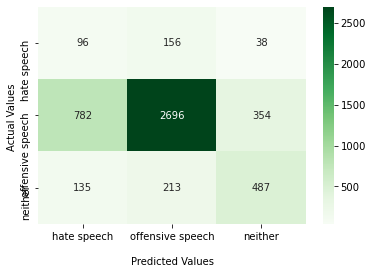

In [16]:
#selecting the algorithm and train it on the train set 
model = GaussianNB()
model = model.fit(X_train, Y_train)

#predicting the class from the test set
y_predictions = model.predict(X_test)

#generating the classification report
report = classification_report(Y_test, y_predictions)
print(report)
accuracy = accuracy_score(Y_test, y_predictions)
mat = confusion_matrix(Y_test, y_predictions)
print(' NAIVE BAYES accuracy score: {}'.format(accuracy))


# diplaying confusion matrix
heat_map = sns.heatmap(mat, annot=True, cmap='Greens', fmt="d")
heat_map.set_xlabel('\nPredicted Values')
heat_map.set_ylabel('Actual Values ')
heat_map.xaxis.set_ticklabels(['hate speech', 'offensive speech', 'neither'])
heat_map.yaxis.set_ticklabels(['hate speech', 'offensive speech', 'neither'])
plt.show()


                                Visualizing the accuracy performance of the used algorithms 

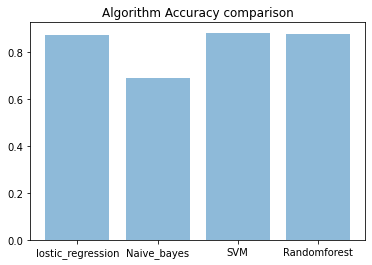

In [17]:
algorithms = ('lostic_regression','Naive_bayes','SVM','Randomforest')
y_axis = np.arange(len(algorithms))
accuracy = [ 0.8706,0.689,0.882, 0.8786]
plt.bar(y_axis,accuracy,align='center',alpha=0.5)
plt.xticks(y_axis,algorithms)
plt.title('Algorithm Accuracy comparison')
plt.show()

                                         USING GRIDSEARCHCV AND PIPELINE to tune the hyperparameters

each ML model has several parameters, and the performance of the models change based of the values we assign to those parameter, so it's important to find the best parameters for machine learning models, but doing so can so exhaustive and time consuming, using gridsearchcv can help with this taks, we create a parameter grid and pass it to the gridsearchcv instance which go through all possibe combinations of parametes.

In [18]:
X, Y = dataset['tweet'], dataset['class']
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, random_state=42, test_size=0.2)


                                     logistic regression using GRIDSEACHCV AND PIPELINE  

In [19]:

pipeline_logistic_regresion = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", LogisticRegression()),
    ]
)

parameters = {
    "tfidf__max_df": (0.5, 0.75, 1.0),
    "tfidf__max_features": (5000, 10000, 11000),
    "tfidf__ngram_range": ((1, 1), (1, 2), (1, 3),(1,4)),
    "tfidf__min_df": (4, 8, 15),
    "clf__solver": ("newton-cg", "lbfgs", "liblinear", "sag", "saga"), 
    "clf__penalty" : ("l2",),
    "clf__C": (100, 10, 1.0, 0.1),
    "clf__max_iter" :(1000,),
    }

grid_search_logistic_regression = GridSearchCV(
    pipeline_logistic_regresion, parameters, n_jobs=-1, cv=3, scoring="accuracy")
grid_search_logistic_regression.fit(X_train, Y_train)



GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': (100, 10, 1.0, 0.1),
                         'clf__max_iter': (1000,), 'clf__penalty': ('l2',),
                         'clf__solver': ('newton-cg', 'lbfgs', 'liblinear',
                                         'sag', 'saga'),
                         'tfidf__max_df': (0.5, 0.75, 1.0),
                         'tfidf__max_features': (5000, 10000, 11000),
                         'tfidf__min_df': (4, 8, 15),
                         'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3),
                                                (1, 4))},
             scoring='accuracy')

In [20]:
print("accuracy score of logistic regression after tuning the hyperparameters : %.3f" %
      grid_search_logistic_regression.best_score_)

accuracy score of logistic regression after tuning the hyperparameters : 0.894


In [21]:
print("logistic regression and TfidfVectirizer best parameters:\n {}".format(grid_search_logistic_regression.best_params_))

logistic regression and TfidfVectirizer best parameters:
 {'clf__C': 1.0, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'tfidf__max_df': 0.5, 'tfidf__max_features': 10000, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 1)}


                                         simple vector machine using GRIDSEACHCV AND PIPELINE  

In [22]:

pipeline_SVM= Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", svm.SVC()),
    ]
)
parameters = {
    "tfidf__max_df": (0.5, 0.75, 1.0),
    "tfidf__max_features": (5000, 10000, 15000),
    "tfidf__ngram_range": ((1, 1), (1, 2), (1, 3), (1, 4)),
    "tfidf__min_df": (4, 8, 15),
    "clf__kernel": ("linear","rbf"),
}
grid_search_svm = GridSearchCV(
    pipeline_SVM, parameters, n_jobs=-1, cv=5, scoring="accuracy")
grid_search_svm.fit(X_train, Y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid={'clf__kernel': ('linear', 'rbf'),
                         'tfidf__max_df': (0.5, 0.75, 1.0),
                         'tfidf__max_features': (5000, 10000, 15000),
                         'tfidf__min_df': (4, 8, 15),
                         'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3),
                                                (1, 4))},
             scoring='accuracy')

In [23]:
print("accuracy score of SVN when tuning the hyperparameters : %.3f" %
      grid_search_svm.best_score_)


accuracy score of SVN when tuning the hyperparameters : 0.903


In [24]:
print("SVM and TfidfVectirizer best parameters:\n {}".format(grid_search_svm.best_params_))

SVM and TfidfVectirizer best parameters:
 {'clf__kernel': 'linear', 'tfidf__max_df': 0.5, 'tfidf__max_features': 5000, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 2)}


                                        Random Forest using GRIDSEACHCV AND PIPELINE  

In [2]:
pipeline_random_forest = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", RandomForestClassifier()),
    ]
)
parameters = {
    "tfidf__max_df": (0.5, 0.75, 1.0),
    "tfidf__max_features": (5000, 10000, 15000), 
    "tfidf__ngram_range": ((1, 1), (1, 2), (1, 3), (1, 4)), 
    "tfidf__min_df": (4, 8, 15), 
    "clf__max_features": ("sqrt","log2"), 
    "clf__n_estimators": (10,100,1000),
    
}
grid_search_rf = GridSearchCV( 
    pipeline_random_forest, parameters, n_jobs=-1, cv=3, scoring="accuracy")
grid_search_rf.fit(X_train, Y_train) 
  


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_features': ('sqrt', 'log2'),
                         'clf__n_estimators': (10, 100, 1000),
                         'tfidf__max_df': (0.5, 0.75, 1.0),
                         'tfidf__max_features': (5000, 10000, 15000),
                         'tfidf__min_df': (4, 8, 15),
                         'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3),
                                                (1, 4))},
             scoring='accuracy')

In [3]:
print("accuracy score of random forest after tuning the hyperparameters : %.3f" %
      grid_search_rf.best_score_)  


accuracy score of random forest after tuning the hyperparameters : 0.901


In [2]:
print("Random Forest and TfidfVectorizer best parameters:\n {}".format(grid_search_rf.best_params_))

Random Forest and TfidfVectorizer best parameters:
 {'clf__max_features': 'sqrt', 'clf__n_estimators': 100, 'tfidf__max_df': 1.0, 'tfidf__max_features': 15000, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 1)}


In [5]:
dill.dump_session('hate_speech.db')